## Librerías

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import cartopy.crs as ccrs	
import cartopy.feature 	
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib
import matplotlib.path as mpath
from scipy import signal
from scipy import stats
from scipy.fftpack import fft
import scipy
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

from wavelib import *
import sys

## Funciones

In [2]:
def graf_corrs_robinson(var,EST,s_comps,s_original, VAR):
    
    '''
    Función para graficar correlación entre componentes
    de un SSA de cierta estación del año. Guarda la figura
    en SALIDAS.
    
    Parametros:
    - var: lista con las correlaciones con cada componente
    - EST: string de la estación del año
    - s_comps: componentes con las series temporales de cada comp.
    - s_original: serie original de precip
    - VAR: string de la variable (geop, tsm, ...)
    
    Devuelve:
    - naden
    '''

    fig, ax = plt.subplots() 
        
    #latitudes and longitudes to plot
    lons, lats = var[0][var[0].dims[1]],var[0][var[0].dims[0]]

    n=len(var)
    
    if n==3:
        gs = gridspec.GridSpec(2,2)
    else:
        gs = gridspec.GridSpec(3,2)
    
    #Grafico las tres componentes juntas
    ax = plt.subplot(gs[n])
    
    #Serie original
    ax.axes.plot(s_original.index, s_original, alpha=1, lw=1, color = 'pink')
    
    #Componentes por separado
    for j in range(n):
        ax.axes.plot(s_original.index, s_comps[j], lw=2)
        
    ax.set_xticks([])
    
    lev_inf = -0.6
    lev_sup = 0.6
    lev_int = 0.1
    clevs = np.arange(lev_inf, lev_sup+lev_int, lev_int)
    
    i=0
    for c in range(n):   
        #Proyección rectangular
        ax = plt.subplot(gs[i],projection=ccrs.Robinson())
        
        crs_latlon = ccrs.PlateCarree()
        ax.add_feature(cartopy.feature.COASTLINE, alpha=.5)
        im=ax.contourf(lons, lats, var[c],cmap="RdBu_r", levels=clevs,extend='both',transform=crs_latlon)

        
        ax.grid(which='both', linewidth=0.3, linestyle='-')
        ax.tick_params(axis='both', which='major', labelsize=8)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.gridlines(linewidth=0.3, linestyle='-')
        
        ax.set_title(str('Componente {}'.format(c+1)), fontsize=15)
        i=i+1
    
    cbar_ax = fig.add_axes([0.98, 0.1, 0.03, 0.8])
    
    fig.colorbar(im, cax=cbar_ax,orientation='vertical') 
    fig.suptitle("Correlacion con {} para {} {}".format(VAR, EST, PER))
    
    fig.savefig(SALIDAS+'Correlacion_'+VAR+'_'+PER+'_'+EST+"_robinson.jpg", dpi=300, bbox_inches='tight')

def graf_corrs_stereo(var,EST,s_comps,s_original, VAR):
    
    '''
    Función para graficar correlación entre componentes
    de un SSA de cierta estación del año. Guarda la figura
    en SALIDAS.
    
    Parametros:
    - var: lista con las correlaciones con cada componente
    - EST: string de la estación del año
    - s_comps: componentes con las series temporales de cada comp.
    - s_original: serie original de precip
    - VAR: string de la variable (geop, tsm, ...)
    
    Devuelve:
    - naden
    '''

    fig, ax = plt.subplots() 
        
    #latitudes and longitudes to plot
    lon, lat = var[0][var[0].dims[1]],var[0][var[0].dims[0]]

    n=len(var)
    
    if n==3:
        gs = gridspec.GridSpec(2,2)
    else:
        gs = gridspec.GridSpec(3,2)
    
    #Grafico las tres componentes juntas
    ax = plt.subplot(gs[n])
    
    #Serie original
    ax.axes.plot(s_original.index, s_original, alpha=1, lw=1, color = 'pink')
    
    #Componentes por separado
    for j in range(n):
        ax.axes.plot(s_original.index, s_comps[j], lw=2)
        
    ax.set_xticks([])
        
    i=0
    for c in range(n):   

        ax = plt.subplot(gs[i],projection=ccrs.SouthPolarStereo(central_longitude=300))

        #Pasamos las latitudes/longitudes del dataset a una reticula para graficar
        lons, lats = np.meshgrid(np.append(lon,360),lat)

        lev_inf = -0.6
        lev_sup = 0.6
        lev_int = 0.1
        clevs = np.arange(lev_inf, lev_sup+lev_int, lev_int)

        crs_latlon = ccrs.PlateCarree()
        ax.set_extent([0,359.9, -90, 0], crs=crs_latlon)
        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        maximo = np.max(np.squeeze(var[c]))
        minimo = np.min(np.squeeze(var[c]))
        limite = np.max([np.abs(minimo),np.abs(maximo)])
        clevels = np.arange(-limite,(limite+limite*2/10),limite*2/10)
        ax.set_boundary(circle, transform=ax.transAxes)
        im=ax.contourf(lons, lats, add_cyclic_point(np.squeeze(var[c])),clevs,transform=crs_latlon,cmap='RdBu_r',extend='both')
        #ax.contour(lons, lats, add_cyclic_point(np.squeeze(var[key])),clevs,colors='k',transform=crs_latlon,extend='both')     
        #plt.colorbar(im,fraction=0.052, pad=0.04,shrink=0.8,aspect=12)
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.1)
        ax.gridlines(crs=crs_latlon, linewidth=0.3, linestyle='-')
        ax.set_title(str('Componente {}'.format(c+1)), fontsize=15)
        
        i=i+1
    
    cbar_ax = fig.add_axes([0.98, 0.1, 0.03, 0.8])        
    fig.colorbar(im, cax=cbar_ax,orientation='vertical')
    #fig.colorbar(im,orientation='vertical')

    fig.suptitle("Correlacion con {} para {} {}".format(VAR, EST, PER))
    #Save in jpg
       
    fig.savefig(SALIDAS+'Correlacion_'+VAR+'_'+PER+'_'+EST+"_stereo.jpg", dpi=300, bbox_inches='tight')

##########################################################################################################

def xr_corr(dict3D, dict1D):
    
    '''
    Función para calcular correlación de una serie temporal
    con cada punto de grilla de un netcdf (serie 1D y serie
    3D) usando la función corr de xarray. 
    
    Parámetros:
        dict3D: un diccionario ("estación":netcdf) con 4 elementos,
        un netcdf para cada estación del año.
        dict1D: un diccionario ("estación":serie temporal) con 4 elementos,
        una serie temporal para cada estación del año.
    
    Devuelve:
        un netcdf con las correlaciones por punto de grilla
    
    
    '''
    
    #Inicializo lista vacia
    corrs={}
    
    #Ciclo para calcular la correlación por estación y componente
    for key in KEYS:
        
        print(key)
             
        ds3D=dict3D[key]
        
        corr_comp=[]
        for n in range(len(dict1D[key])):
            
            print(n)
            
            
            ds1D=dict1D[key][n]

            corr_comp.append(xr.corr(ds3D,ds1D,'time'))
            
        print('largo: {}'.format(len(corr_comp)))
        corrs[key] = corr_comp
    
    
    return corrs

#####################################
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])


## Constantes

In [3]:
# Para serie temporal de anomalias CENTRO ARGENTINA
LAT_SUR_M=-35
LAT_NOR_M=-26
LON_OESTE_M=294
LON_ESTE_M=299

#Para calculos CENTRO ARGENTINA
LAT_SUR=-42
LAT_NOR=-16
LON_OESTE=287
LON_ESTE=306

#Para graficar CENTRO ARGENTINA
LAT_SUR_G=-39
LAT_NOR_G=-19
LON_OESTE_G=290
LON_ESTE_G=303

#Periodo largo
ANIO_MIN1=1930
ANIO_MAX1=2016

#Periodo corto
ANIO_MIN2=1981
ANIO_MAX2=2010

#Periodo en formato
TIMEMIN1 = str(ANIO_MIN1)+'-01-01'
TIMEMAX1 = str(ANIO_MAX1)+'-12-31'

#Periodo en formato
TIMEMIN2 = str(ANIO_MIN2)+'-01-01'
TIMEMAX2 = str(ANIO_MAX2)+'-12-31'

#Periodo en el cual se calculará la media para las anomalías
TIMEMIN_MEDIA = '1951-01-01'
TIMEMAX_MEDIA = '1980-12-31'

#Path a los datos
DATOS_PP_GPCC='/datos/Datos_Dalia/precip.mon.total.v2018.nc'
DATOS_SST='/datos/Datos_Dalia/sst.mnmean.nc'
DATOS_PP_CRU='/datos/Datos_Dalia/cru_ts4.05.1901.2020.pre.dat.nc'
DATOS_GEOP='/datos/Datos_Dalia/geopotential_monthly_averaged.nc'
DATOS_MSLP='/datos/Datos_Dalia/mean_sea_level_pressure_monthly_averaged.nc'

#Path para guardar figuras
SALIDAS='/home/dalia.panza/Proy_IAI/Salidas/SSA/'

#Vector con nombres de las estaciones del año
KEYS=['Verano (DJF)', 'Otoño (MAM)', 'Invierno (JJA)', 'Primavera (SON)']

## Período

In [4]:
per=1

if (per==1):
    
    TIMEMIN=TIMEMIN1
    TIMEMAX=TIMEMAX1
    PER='(1930-2016)'
    
else:
    
    TIMEMIN=TIMEMIN2
    TIMEMAX=TIMEMAX2
    PER='(1981-2010)'

## Lectura de datos

In [5]:
# Abro el archivo usando xarray
ds_pp = xr.open_dataset(DATOS_PP_GPCC)

#Recorte temporal y espacial
pp_recorte = ds_pp.sel(lat=slice(LAT_NOR, LAT_SUR), lon=slice(LON_OESTE,LON_ESTE))['precip']

del ds_pp

#Remuestreo los datos dividiendo por estaciones (DEF-MAM-JJA-SON)
pp_est = pp_recorte.resample(time="QS-DEC").sum()

pp_est={KEYS[0]:pp_est.sel(time=pp_est["time.month"]==12),
        KEYS[1]:pp_est.sel(time=pp_est["time.month"]==3),
        KEYS[2]:pp_est.sel(time=pp_est["time.month"]==6),
        KEYS[3]:pp_est.sel(time=pp_est["time.month"]==9)}

#Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
pp_est[KEYS[0]]=pp_est[KEYS[0]].sel(time=slice(pp_est[KEYS[0]]['time'][1],
                                                pp_est[KEYS[0]]['time'][-2]))




## Cálculo de anomalías

In [6]:
#Anomalía para cada punto de reticula

"""Para la serie original"""
pp_media = pp_recorte.sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                               lon=slice(LON_OESTE_M,LON_ESTE_M),
                               time=slice(TIMEMIN_MEDIA,TIMEMAX_MEDIA)).mean()
pp_anom =pp_recorte.sel(time=slice(TIMEMIN,TIMEMAX)) - pp_media

"""Por estación"""
#Inicializo lista vacia 
pp_est_anom=[]

#Ciclo para iterar en el diccionario de datos de pp
for key in KEYS:
    #Hago un recorte espacial para el centro de Arg y el periodo 51-80
    pp_media = pp_est[key].sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                               lon=slice(LON_OESTE_M,LON_ESTE_M),
                               time=slice(TIMEMIN_MEDIA,TIMEMAX_MEDIA)).mean()
    #A la lista vacía le agrego la anomalía para la estación correspondiente
    pp_est_anom.append(pp_est[key].sel(time=slice(TIMEMIN,TIMEMAX))-pp_media)
    
    del pp_media

#Paso de list a dict 
pp_est_anom= dict(zip(KEYS, pp_est_anom))

"""Anual"""
pp_ann_anom=pp_anom.resample(time="Y").sum()

## Promedio regional de anomalías

In [7]:
#Promedio regional con pesos segun latitud
weights = np.cos(np.deg2rad(pp_recorte.lat))

"""Para la serie original"""
pp_anom_PromReg = pp_anom.sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                          lon=slice(LON_OESTE_M,LON_ESTE_M)).weighted(weights).mean(("lon", "lat"))
pp_anom_PromReg = pp_anom_PromReg.to_dataframe()
"""Por estación"""
#Inicializo lista vacía
pp_anom_est_PromReg=[]

#Data array con valores entre 0 y 1 para hacer promedio con peso x latitud

for key in KEYS:
    da_weighted = pp_est_anom[key].sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                                      lon=slice(LON_OESTE_M,LON_ESTE_M)).weighted(weights)
    pp_anom_est_PromReg.append(da_weighted.mean(("lon", "lat")))

                      
#Paso de list a dict
pp_anom_est_PromReg= dict(zip(KEYS, pp_anom_est_PromReg))

#del pp_recorte, ds_weighted, pp_est_anom, pp_est

#Paso los DataArrays a pandas DataFrames
for key in KEYS:
    pp_anom_est_PromReg[key] = pp_anom_est_PromReg[key].to_dataframe()

"""Anual"""
pp_ann_anom_PromReg = pp_ann_anom.sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                          lon=slice(LON_OESTE_M,LON_ESTE_M)).weighted(weights).mean(("lon", "lat"))
pp_ann_anom_PromReg = pp_ann_anom_PromReg.to_dataframe()

## Singular Spectrum Analysis

86
87
87
87


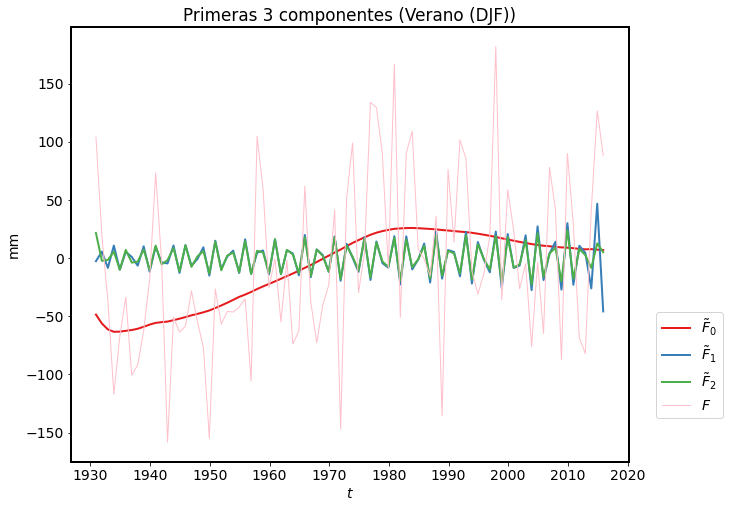

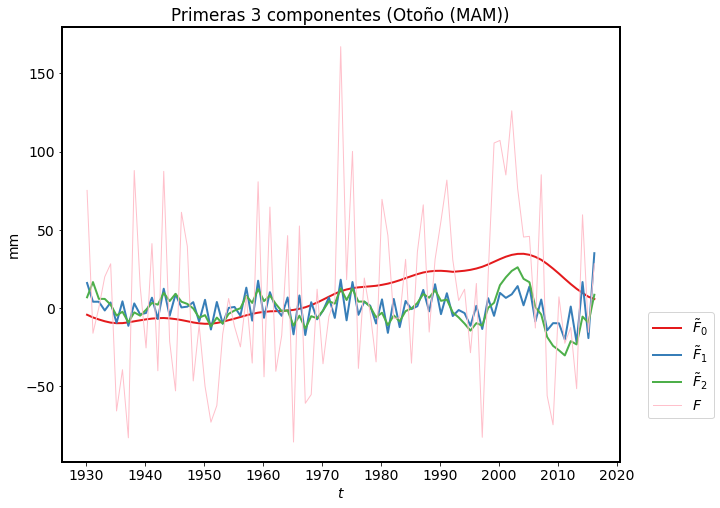

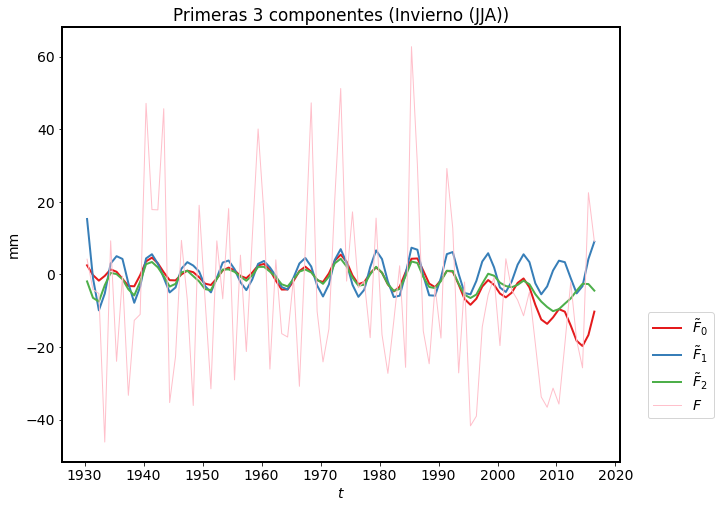

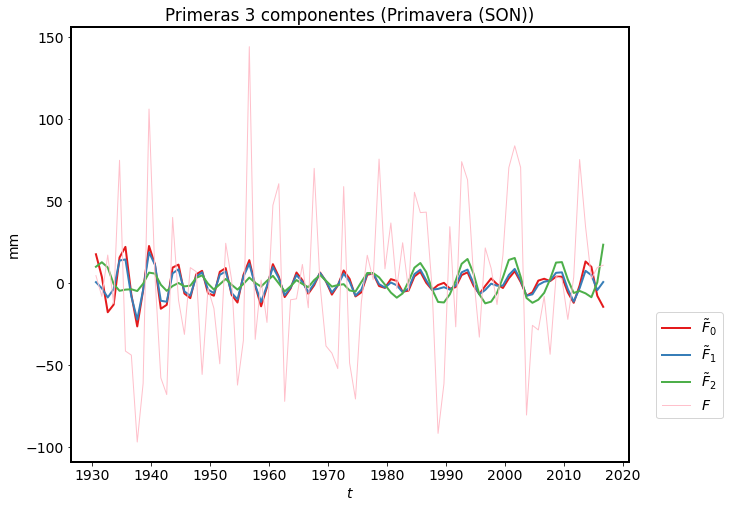

In [8]:
# Diccionario vacío donde se guardaran las primeras componentes 

ssa_components = {}

for key in KEYS:
    
    #Tomo los datos de verano del diccionario
    pp = pp_anom_est_PromReg[key]

    #Extraigo N como la cantidad total de fechas
    N = len(pp)
    print(N)
    #Tamaño de la ventana
    L = 25
    K = N - L + 1

    X_est = np.column_stack([pp[i:i+L] for i in range(0,K)])

    d = np.linalg.matrix_rank(X_est) # The intrinsic dimensionality of the trajectory space.

    U, Sigma, V = np.linalg.svd(X_est)
    
    V = V.T 

    X_elem_est = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

    if not np.allclose(X_est, X_elem_est.sum(axis=0), atol=1e-4):
        print("WARNING: The sum of X's elementary matrices is not equal to X!")

    n = min(3,d) # In case of noiseless time series with d < 12.

    # Fiddle with colour cycle - need more colours!
    fig = plt.figure()
    ax = plt.subplot()
    color_cycle = cycler(color=plt.get_cmap('Set1').colors)
    ax.axes.set_prop_cycle(color_cycle)

    t = pp.index

    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    for i in range(n):
        F_i = X_to_TS(X_elem_est[i])
        ax.axes.plot(t, F_i, lw=2)

    ax.axes.plot(t, pp, alpha=1, lw=1, color = 'pink')
    ax.set_xlabel("$t$")
    ax.set_ylabel("mm")
    legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
    ax.set_title("Primeras 3 componentes ("+key+')')
    ax.legend(legend, loc=(1.05,0.1));

    fig.savefig(SALIDAS + 'SSA_'+str(n)+'_componentes_ventana'+str(L)+'_'+key+".jpg", dpi=300, bbox_inches='tight')
    

    tseries = []

    for i in range(n):
        
        #Obtengo serie temporal correspondiente a cada componente
        F_i = X_to_TS(X_elem_est[i])
        
        #Paso de pandas.DataFrame a xarray.DataArray
        da = xr.DataArray(data = F_i, dims=['time'], coords={'time':t})
        
        #Guardo cada dataarray en tseries
        tseries.append(da)
    
    #Guardo cada tseries en el diccionario
    ssa_components[key]=tseries
    
    del tseries

## Datos para correlacionar

### SST

In [9]:
# Abro el archivo usando xarray
ds_tsm=xr.open_dataset(DATOS_SST)
#Recorte temporal
tsm_recorte = ds_tsm.sel(time=slice(TIMEMIN,TIMEMAX))['sst']

#Agrupando por meses, le resto la media climatologica mensual a los datos. Asi
#obtengo anomalías de tsm. 
tsm_anom=tsm_recorte.groupby('time.month')-tsm_recorte.groupby('time.month').mean('time')


#Remuestreo de los datos por estación (DJF-MAM-JJA-SON)
tsm_anom_est=tsm_anom.resample(time='QS-DEC').mean()

#Guardo los datos separados por estación en un diccionario
tsm_anom_est={KEYS[0]:tsm_anom.sel(time=tsm_anom["time.month"]==12),
              KEYS[1]:tsm_anom.sel(time=tsm_anom["time.month"]==3),
              KEYS[2]:tsm_anom.sel(time=tsm_anom["time.month"]==6),
              KEYS[3]:tsm_anom.sel(time=tsm_anom["time.month"]==9)}
 

#Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
tsm_anom_est[KEYS[0]]=tsm_anom_est[KEYS[0]].sel(time=slice(tsm_anom_est[KEYS[0]]['time'][0],
                                                           tsm_anom_est[KEYS[0]]['time'][-2]))

del ds_tsm, tsm_anom, tsm_recorte


### Geopotencial

In [10]:
# Anomalías de geopotencial

#Hemisferio sur
LAT_NOR_HS=2
LAT_SUR_HS=-90

# Abro el archivo usando xarray
ds_geo=xr.open_dataset(DATOS_GEOP)

alts = [200,500,850]
geops = []



for alt in alts:

    # Recorte espacial temporal
    geo_recorte = ds_geo.sel(time=slice(TIMEMIN,TIMEMAX), latitude=slice(LAT_NOR_HS, LAT_SUR_HS))['z'].sel(level=alt)

    # #Agrupando por meses, le resto la media climatologica mensual a los datos. Asi
    # #obtengo anomalías de tsm. 
    geo_anom=geo_recorte.groupby('time.month')-geo_recorte.groupby('time.month').mean('time')

    #Remuestreo de los datos por estación (DJF-MAM-JJA-SON)
    geo_anom_est=geo_anom.resample(time='QS-DEC').mean()

    #Guardo los datos separados por estación en un diccionario
    geo_anom_est={KEYS[0]:geo_anom.sel(time=geo_anom["time.month"]==12),
                  KEYS[1]:geo_anom.sel(time=geo_anom["time.month"]==3),
                  KEYS[2]:geo_anom.sel(time=geo_anom["time.month"]==6),
                  KEYS[3]:geo_anom.sel(time=geo_anom["time.month"]==9)}


    #Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
    geo_anom_est[KEYS[0]]=geo_anom_est[KEYS[0]].sel(time=slice(geo_anom_est[KEYS[0]]['time'][0],
                                                                geo_anom_est[KEYS[0]]['time'][-1]))
    
    geops.append(geo_anom_est)

    del geo_anom, geo_recorte

geo200_anom_est = geops[0]
geo500_anom_est = geops[1]
geo850_anom_est = geops[2] 

del geops, ds_geo

### Presion media a nivel del mar

In [11]:
# Abro el archivo usando xarray
ds_mslp=xr.open_dataset(DATOS_MSLP)

#Recorte espacial y temporal
mslp_recorte = ds_mslp.sel(time=slice(TIMEMIN,TIMEMAX), latitude=slice(LAT_NOR_HS, LAT_SUR_HS))['msl']


#Agrupando por meses, le resto la media climatologica mensual a los datos. Asi
#obtengo anomalías de mslp. 
mslp_anom=mslp_recorte.groupby('time.month')-mslp_recorte.groupby('time.month').mean('time')


#Remuestreo de los datos por estación (DJF-MAM-JJA-SON)
mslp_anom_est=mslp_anom.resample(time='QS-DEC').mean()

#Guardo los datos separados por estación en un diccionario
mslp_anom_est={KEYS[0]:mslp_anom.sel(time=mslp_anom["time.month"]==12),
               KEYS[1]:mslp_anom.sel(time=mslp_anom["time.month"]==3),
               KEYS[2]:mslp_anom.sel(time=mslp_anom["time.month"]==6),
               KEYS[3]:mslp_anom.sel(time=mslp_anom["time.month"]==9)}
 

#Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
mslp_anom_est[KEYS[0]]=mslp_anom_est[KEYS[0]].sel(time=slice(mslp_anom_est[KEYS[0]]['time'][0],
                                                            mslp_anom_est[KEYS[0]]['time'][-1]))

del ds_mslp, mslp_anom, mslp_recorte

## Calculo de correlaciones

In [12]:

#Precipitación + sst
corr_c1_sst = xr_corr(tsm_anom_est, ssa_components)
#Precipitación + geopotencial
corr_c1_geo200 = xr_corr(geo200_anom_est, ssa_components)
corr_c1_geo500 = xr_corr(geo500_anom_est, ssa_components)
corr_c1_geo850 = xr_corr(geo850_anom_est, ssa_components)
#Precipitación + mslp
corr_c1_mslp = xr_corr(mslp_anom_est, ssa_components)

#Cada una de estas variables es un diccionario, cada componente es una
#estación (verano, otoño, primavera o verano). Dentro de cada componente
#se guarda una lista, con las correlaciones por componente (5). 
#En total hay 12 correlaciones. 


Verano (DJF)
0
1
2
largo: 3
Otoño (MAM)
0
1
2
largo: 3
Invierno (JJA)
0
1
2
largo: 3
Primavera (SON)
0
1
2
largo: 3
Verano (DJF)
0
1
2
largo: 3
Otoño (MAM)
0
1
2
largo: 3
Invierno (JJA)
0
1
2
largo: 3
Primavera (SON)
0
1
2
largo: 3
Verano (DJF)
0
1
2
largo: 3
Otoño (MAM)
0
1
2
largo: 3
Invierno (JJA)
0
1
2
largo: 3
Primavera (SON)
0
1
2
largo: 3
Verano (DJF)
0
1
2
largo: 3
Otoño (MAM)
0
1
2
largo: 3
Invierno (JJA)
0
1
2
largo: 3
Primavera (SON)
0
1
2
largo: 3
Verano (DJF)
0
1
2
largo: 3
Otoño (MAM)
0
1
2
largo: 3
Invierno (JJA)
0
1
2
largo: 3
Primavera (SON)
0
1
2
largo: 3


## Mapas de correlaciones

In [13]:
print(len(corr_c1_mslp[key]))

3


Verano (DJF)
Otoño (MAM)
Invierno (JJA)
Primavera (SON)


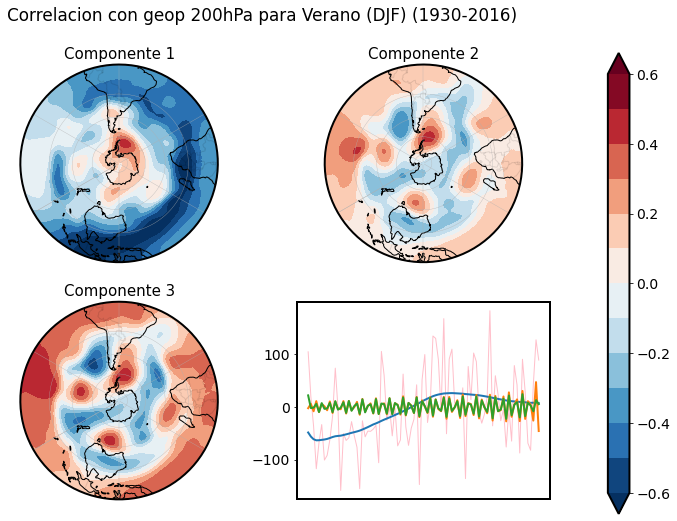

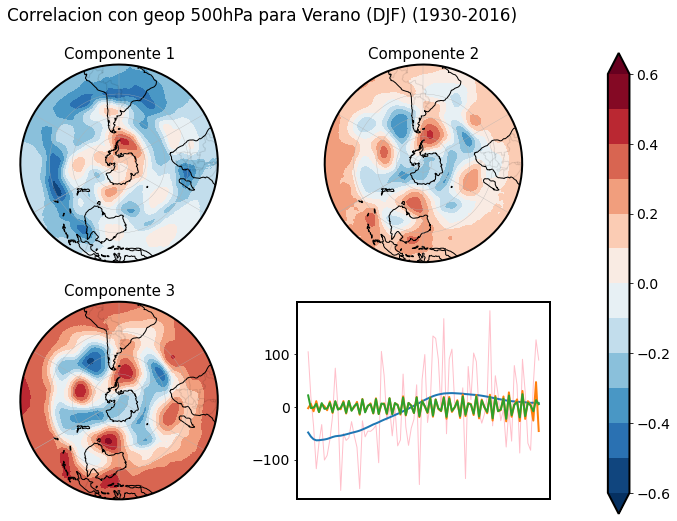

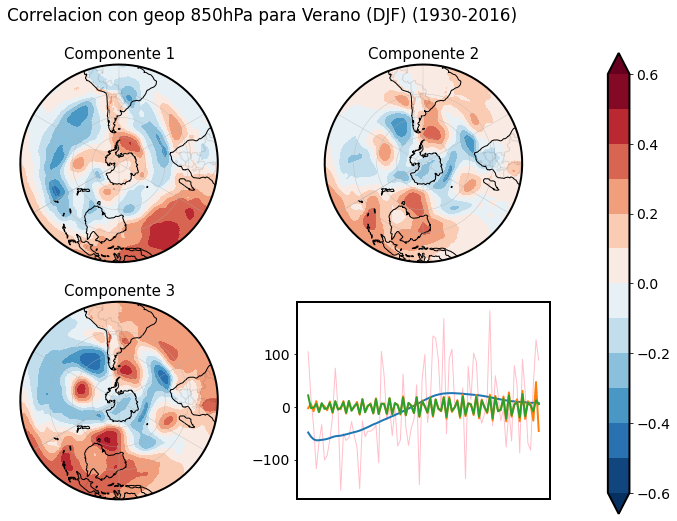

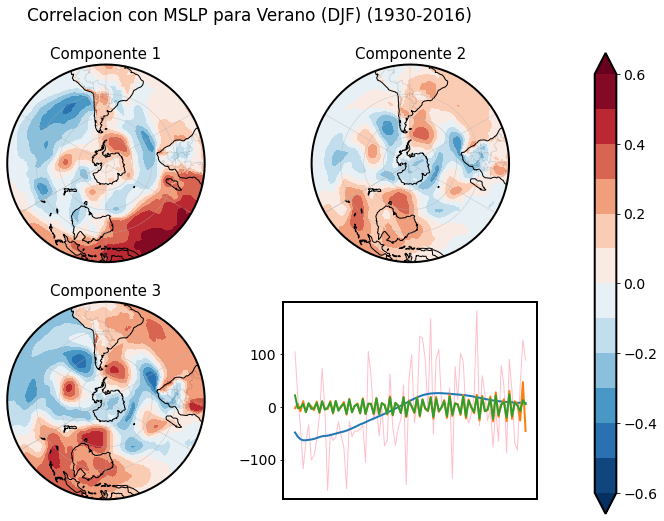

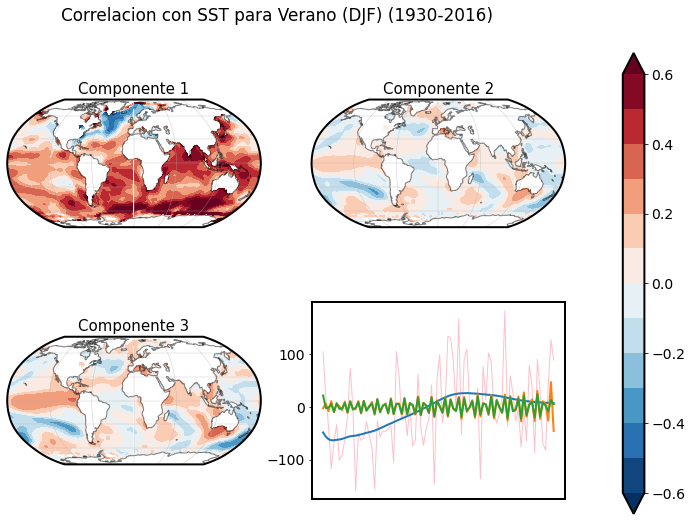

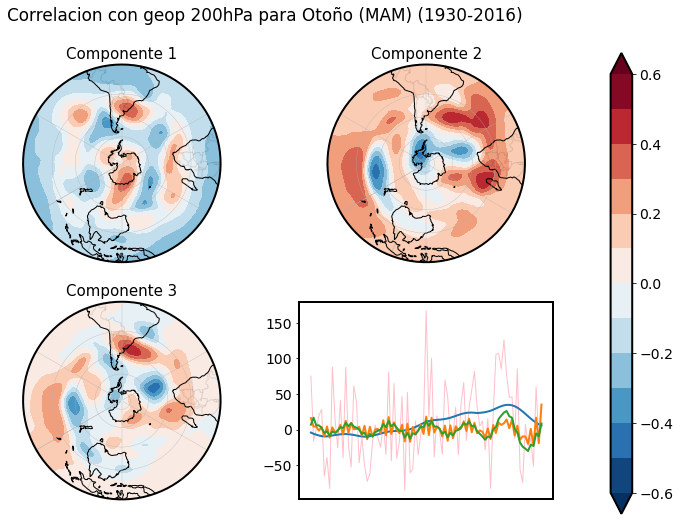

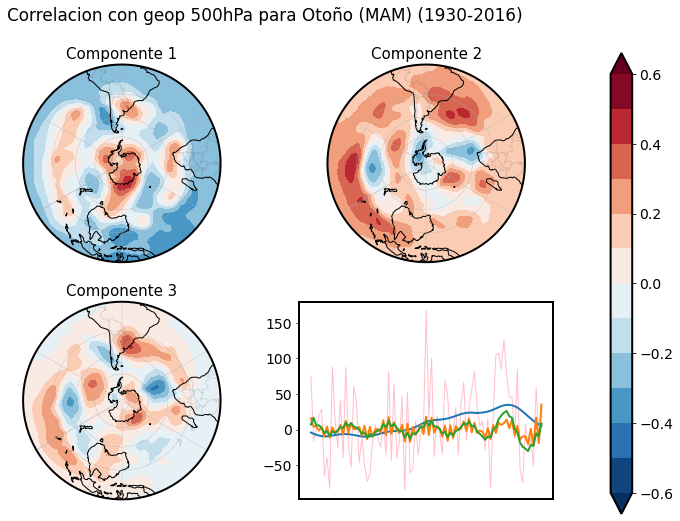

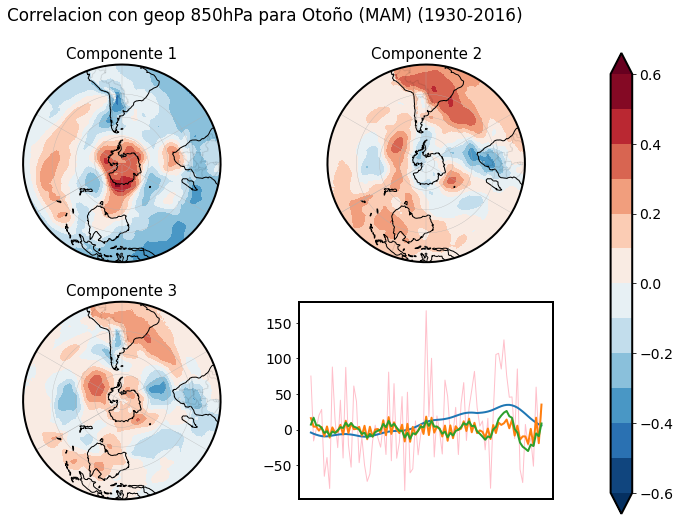

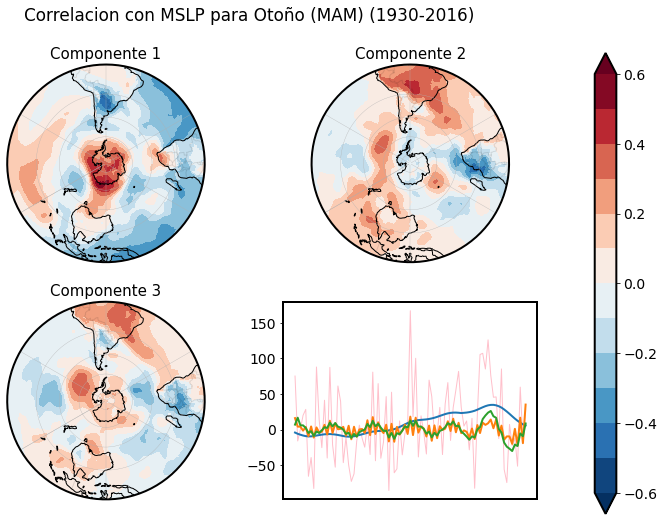

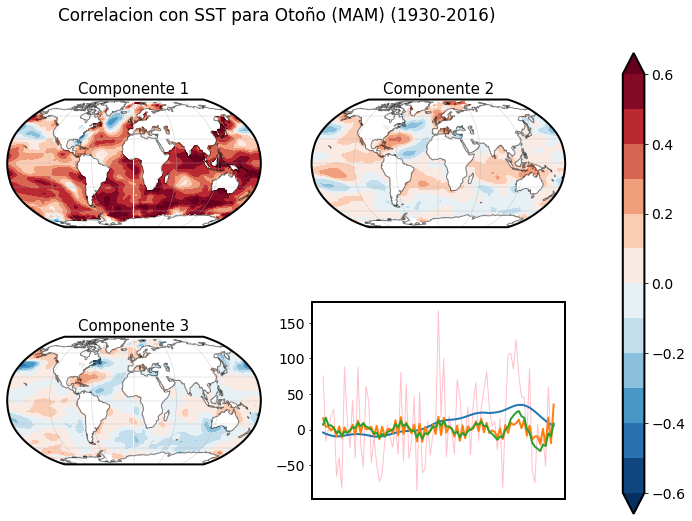

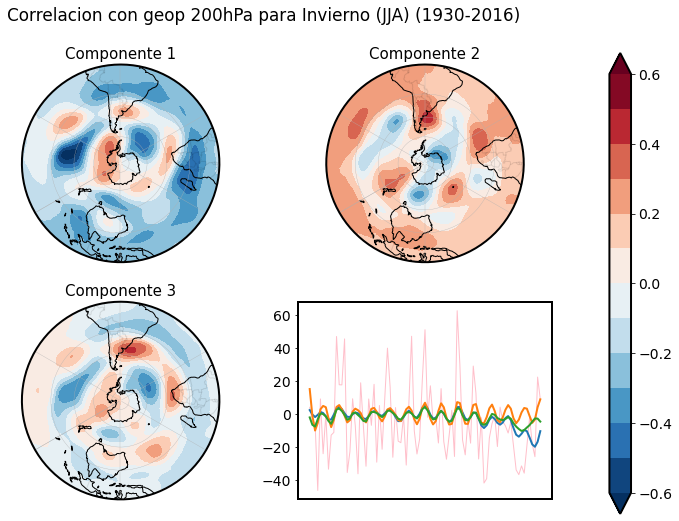

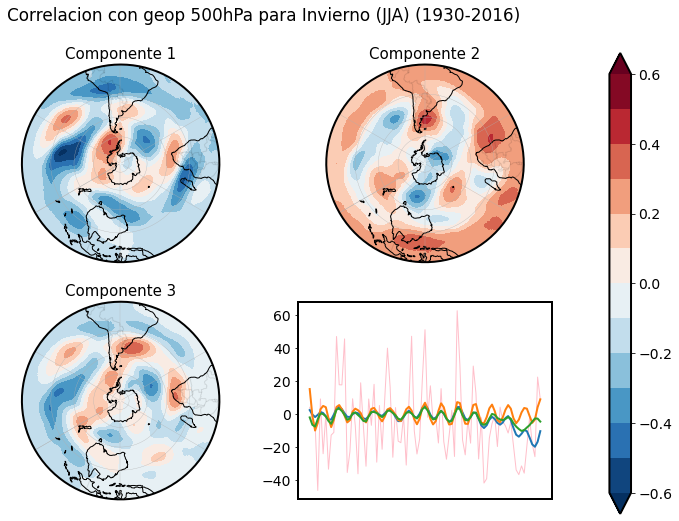

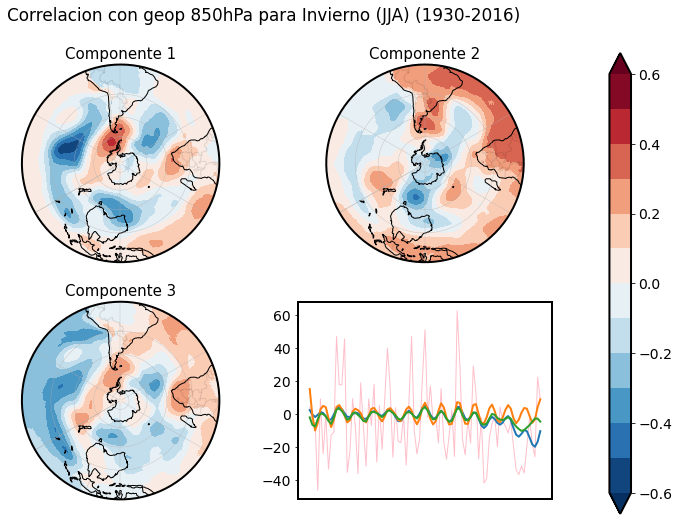

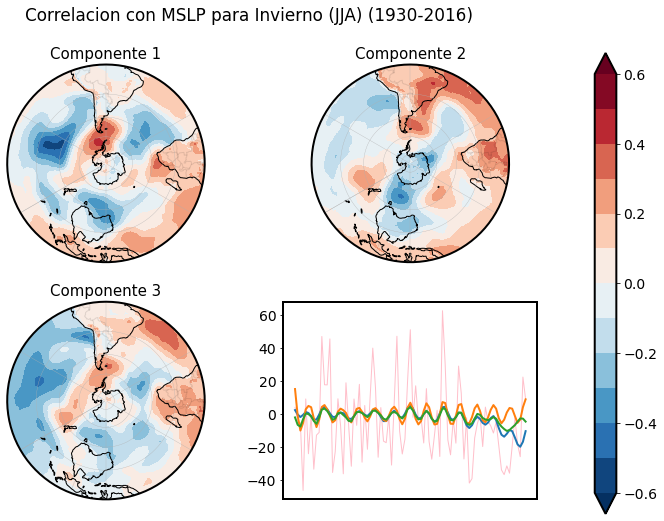

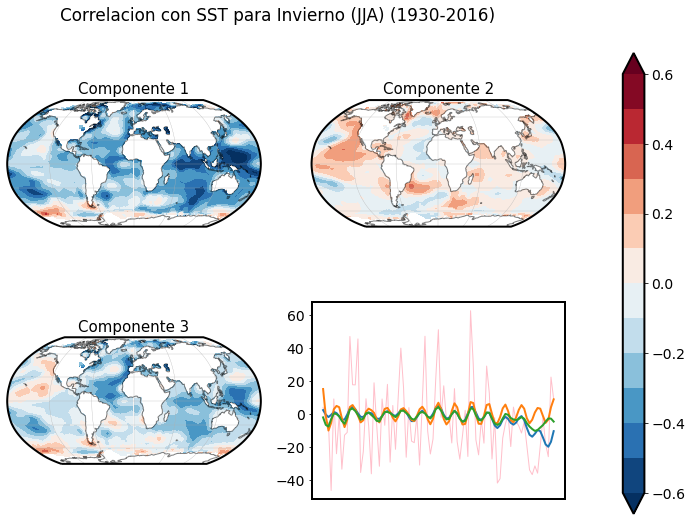

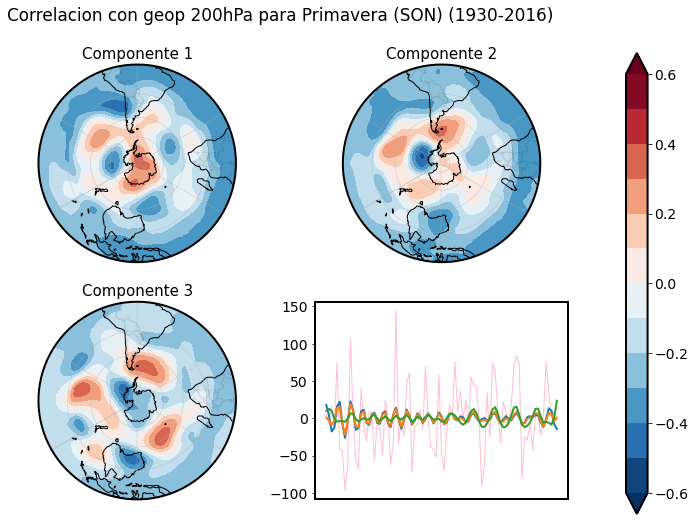

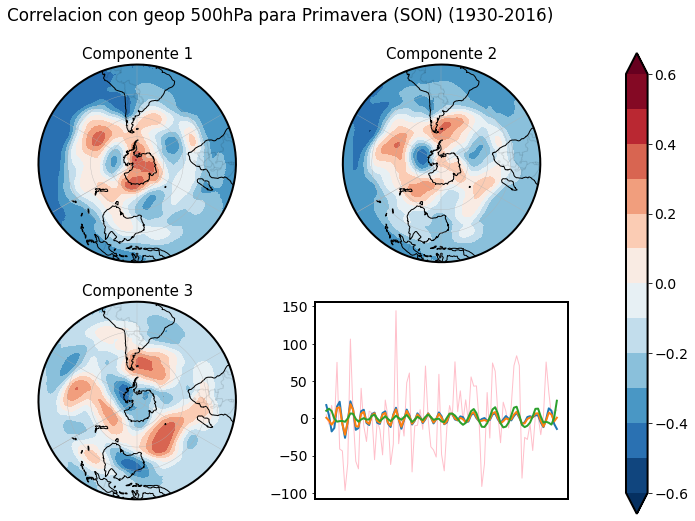

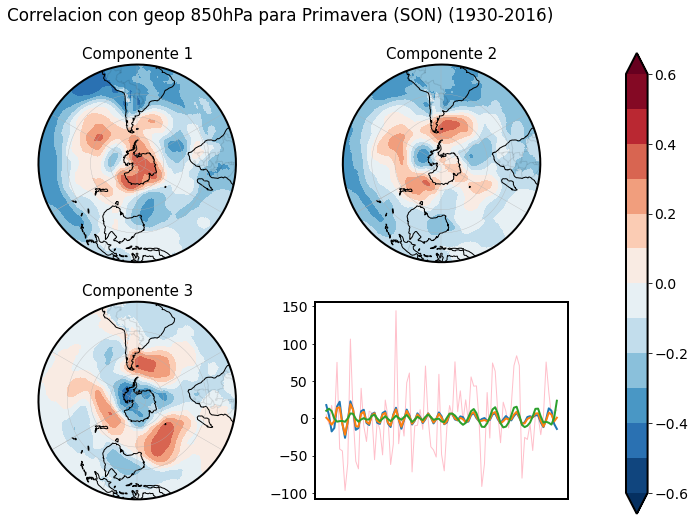

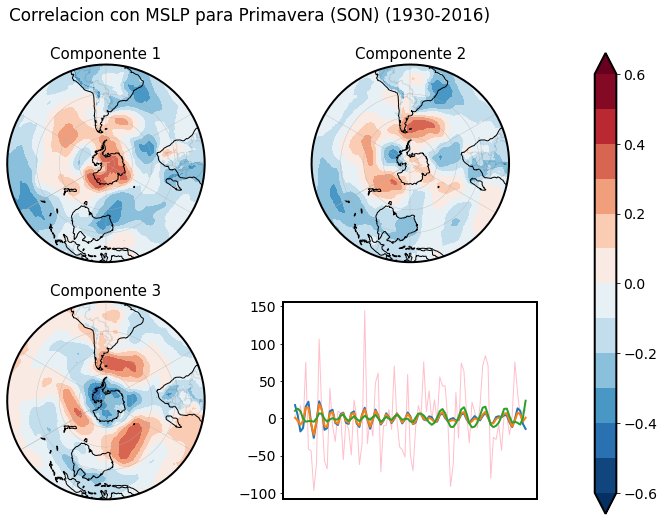

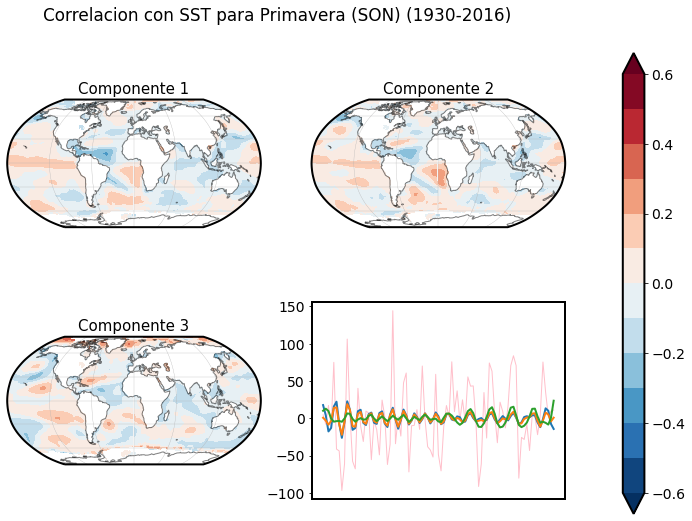

In [15]:
#graf_corrs_stereo(var,EST,s_comps,s_original, VAR)

for key in KEYS:
    
    print(key)

    # Precipitación + geopotencial
    graf_corrs_stereo(corr_c1_geo200[key], key, ssa_components[key], pp_anom_est_PromReg[key], 'geop 200hPa')
    graf_corrs_stereo(corr_c1_geo500[key], key, ssa_components[key], pp_anom_est_PromReg[key],'geop 500hPa')
    graf_corrs_stereo(corr_c1_geo850[key], key, ssa_components[key], pp_anom_est_PromReg[key], 'geop 850hPa')

    #Precipitación + presión
    graf_corrs_stereo(corr_c1_mslp[key], key, ssa_components[key], pp_anom_est_PromReg[key], 'MSLP')
    
    #Precipitación + temp. sup. mar
    graf_corrs_robinson(corr_c1_sst[key], key, ssa_components[key], pp_anom_est_PromReg[key], 'SST')